In [2]:
#libraries necessary

import sys
import numpy as np
import os
import cv2
import h5py
import logging
import tensorflow as tf
from math import log10
from collections import OrderedDict
import matplotlib.pyplot as plt
from typing import Iterator, Tuple
from dataset_generator_h5 import DatasetGenerator
from layers import weight_variable,bias_variable,conv2d,l2_loss

In [3]:
##########
GLOBAL_PATH='MODEL_FINAL/'
##########

In [1]:
PAN_SIZE=1
TOT_XS_SIZE=4
PXS_SIZE=4



PATH_TRAINING='TRAINING/'
PATH_VERIFICATION='VERIFICATION/'
PATH_VALIDATION='VALIDATION/'



PATH_INPUT='INPUT/'
PATH_OUTPUT='OUTPUT/'
test_save=GLOBAL_PATH+'TEST_SAVE/'
if not os.path.exists(test_save):
            os.makedirs(test_save)

INPUT_SIZE=5
OUTPUT_SIZE=4
SIZE_PATCH=33

MODEL_PATH_SAVE=GLOBAL_PATH+'SRCNN.ckpt'



NameError: name 'GLOBAL_PATH' is not defined

In [4]:
##PARAMETERS TO TUNE####

rec_save=1#400 #How often do you save the model? every  400 iterations for instance
dropout=0.7
LEARNING_RATE=0.0001

#Network parameters
LAYERS=3
FILTERS_NB=[INPUT_SIZE,64,32,OUTPUT_SIZE]
FILTERS_WIDTH=[9,5,5]

## TUNE MODEL TRAINING
DEFAULT_BATCH_SIZE = 36
DEFAULT_EPOCHS = 2#500
DEFAULT_ITERATIONS =3#850
DEFAULT_VERIF = 50
DEFAULT_VALID=4

In [5]:
def read_data(path):
    '''
    Read .tif image
    :path where is the image
    returns data as an array
    '''

    data=cv2.imread(path,cv2.IMREAD_UNCHANGED)
    return data

In [6]:
def prepare_xs_hr_full(path,size_hr):
    '''
    Upsample and concatenate XS x 4 bands and save it to .h5 format
    :parameter path: xs1.tif,xs2.tif,xs3.tif and xs4.tif are stored
    :parameter size_hr: HR size
    '''
    
    NAME_XS1='xs1.tif'
    NAME_XS2='xs2.tif'
    NAME_XS3='xs3.tif'
    NAME_XS4='xs4.tif'
    INPUT_XS_CHANNELS=1
    
    xs1=read_data(path+NAME_XS1)
    xs2=read_data(path+NAME_XS2)
    xs3=read_data(path+NAME_XS3)
    xs4=read_data(path+NAME_XS4)
    xs1=xs1/255.
    xs2=xs2/255.
    xs3=xs3/255.
    xs4=xs4/255.

    size_lr=[xs1.shape[0],xs1.shape[1]]
    xs1_ph=tf.placeholder(tf.float64, [size_lr[0],size_lr[1]], name='xs1_placeholder')
    xs2_ph=tf.placeholder(tf.float64, [size_lr[0],size_lr[1]], name='xs2_placeholder')
    xs3_ph=tf.placeholder(tf.float64, [size_lr[0],size_lr[1]], name='xs3_placeholder')
    xs4_ph=tf.placeholder(tf.float64, [size_lr[0],size_lr[1]], name='xs4_placeholder')
    
    xs1_t=tf.reshape(xs1_ph,[1,size_lr[0],size_lr[1],INPUT_XS_CHANNELS],name='reshape_xs1')
    xs2_t=tf.reshape(xs2_ph,[1,size_lr[0],size_lr[1],INPUT_XS_CHANNELS],name='reshape_xs2')
    xs3_t=tf.reshape(xs3_ph,[1,size_lr[0],size_lr[1],INPUT_XS_CHANNELS],name='reshape_xs3')
    xs4_t=tf.reshape(xs4_ph,[1,size_lr[0],size_lr[1],INPUT_XS_CHANNELS],name='reshape_xs4')
    xs_hr=tf.concat((xs1_t,xs2_t,xs3_t,xs4_t),-1,name='concat_xs')

    xs_hr=tf.image.resize_images(xs_hr, [size_hr[0], size_hr[1]])
    xs_hr=tf.cast(xs_hr,tf.float64,name='cast_xs_hr')


    with tf.Session() as sess:
        Xs_hr= sess.run(xs_hr,feed_dict={xs1_ph: xs1,xs2_ph: xs2,xs3_ph: xs3,xs4_ph:xs4})
        with h5py.File(path+'xs_hr.h5','w') as hf:
            hf.create_dataset('data',data=Xs_hr)
            print('File '+path+'xs_hr.h5'+' created')

In [7]:
def standardize(data):
    '''
    Standardize the input data (Panchromatique+4xXS)
    :param data to be standardized (size nb_batches x WIDTH x HEIGHT x number of channels) -->
    number of channels of the data (5=Panchromatique+4xXS)
    
    returns data standardized size nb_batches x WIDTH x HEIGHT x number of channels) 
    
    '''
    WIDTH=data.shape[1]
    HEIGHT=data.shape[2]
    channels=data.shape[3]
    
    mean_t=np.mean(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    std_t=np.std(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    data=data-mean_t/std_t
    
    #For normalization 
    min_t=np.amin(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    max_t=np.amax(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    data=(data-min_t)/(max_t-min_t)

    return data
    
    

In [8]:
class CustomCNN():
    
    def __init__(self):
        """
        Initializes the custom CNN 
        """
        tf.reset_default_graph()
        self.X_placeholder = tf.placeholder(tf.float32, [None, None, None, (PAN_SIZE+TOT_XS_SIZE)], name='X_placeholder')
        self.y_placeholder = tf.placeholder(tf.float32, [None, None, None,PXS_SIZE], name='y_placeholder')
        self.keep_prob = tf.placeholder(tf.float32)
            
        self.predictions,self.variables=self.CNN_baseline(self.X_placeholder,self.keep_prob)
        self.l2_loss=l2_loss(self.y_placeholder,self.predictions)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, name='optimizer/adam').minimize(self.l2_loss,name='optimizer')
        
    def CNN_baseline(self,x,keep_prob,layers =LAYERS,filters_nb=FILTERS_NB, filters_widths=FILTERS_WIDTH):
        """
        Creates a new convolutional unet for the given parametrization.

        :param x: input tensor, shape [?,nx,ny,channels_in]
        :param keep_prob: probability for dropout
        :param layers: number of layers of the network
        :param filters_nb: number of filters for each layer
        :param filters_widths: size of the filter for each layer
        """

        logging.info("Layers {layers},Number of filters {filters_nb}, filter size {filters_widths}".format(layers=layers,filters_nb=filters_nb,
                                                                                                     filters_widths=filters_widths))
        # Placeholder for the input image
        nx = tf.shape(x)[1]
        ny = tf.shape(x)[2]
        x_image = tf.reshape(x, tf.stack([-1,nx,ny,INPUT_SIZE]))
        in_node = x_image
        batch_size = tf.shape(x_image)[0]


        weights = []
        biases = []
        convs = []
        h_convs = OrderedDict()

        # Patch extraction and Non linear Mapping
        for layer in range(0,layers):
            stddev=np.sqrt(2/(filters_nb[layer+1]*filters_widths[layer]**2))
            w=weight_variable([filters_widths[layer], filters_widths[layer], filters_nb[layer], filters_nb[layer+1]], stddev)
            b = bias_variable([filters_nb[layer+1]])
            conv_ = conv2d(in_node, w,keep_prob)

        #ORIGINAL VERION FROM SRCNNN
            if layer<(layers-1):
                h_convs[layer] = tf.nn.relu(conv_ + b)
                in_node = h_convs[layer]
            else:
                output_map=conv_ + b 
            weights.append(w)
            biases.append(b)
            convs.append(conv_)


   
        h_convs["out"] = output_map


        variables = []
        for w in weights:
            variables.append(w)

        for b in biases:
            variables.append(b)



        return output_map, variables
    def train(self, *, epochs: int, iterations: int, batch_size: int, verification_size: int,restore:bool,model_stored: str, disp_verif: bool, data_aug: bool ):
        """
        Train the model
    
        :param epochs: number of epochs
        :param iterations: number of iterations
        :param batch_size: size of the batch
        :param verification_size: number of elements in the verification set
        :param restore: boolean set to False if no model is restored to train the network and True in the contrary case
        :param disp_verif: boolean that allows to display image summary of the verification set at the end of each epoch
        :param data_aug: train with data augmentation
        
        returns save_path (path of the last model stored),psnr_tab_train (array with psnr at each training iteration),psnr_tab_verif (array with verification psnr at each epoch ) 
        """
        #STORE PSNR for ANALYSIS
        psnr_tab_train=np.zeros(iterations*epochs)
        file_train = open(GLOBAL_PATH+'psnr_train.txt','w') 
        psnr_tab_verif=np.zeros(epochs)
        file_verif = open(GLOBAL_PATH+'psnr_verif.txt','w') 
        

        
        
        #VERIFICATION SETTING
        verification_len = verification_size
        verification_generator = DatasetGenerator.from_root_folder(PATH_VERIFICATION, batch_size=verification_len)
        verification_generator=verification_generator.shuffled()
        verification_generator=verification_generator.__iter__()
        X_verif,Y_verif=verification_generator.__next__()
        X_verif=standardize(X_verif)
        
        train_len = batch_size*iterations
        training_generator = DatasetGenerator.from_root_folder(PATH_TRAINING, batch_size=batch_size,max_data_size=50000)
        print('Training')
        saver = tf.train.Saver()
        with tf.Session() as sess:
            
            #Model restored
            if restore:
                self.restore(sess,saver,model_stored )
            else:
                sess.run(tf.global_variables_initializer())
                
            counter =0      
            for epoch in range(epochs):
                train_loss = 0
                train_psnr=0
                train_accuracy = 0
                step = 0
                training_generator_ite=training_generator.shuffled()
                training_generator_ite=training_generator_ite.__iter__()
                
                for ite in range(iterations):
                    X,Y =training_generator_ite.__next__()
                    X=standardize(X)
                    if data_aug:
                        X,Y=training_generator_ite.__data_aug__(X,Y)
                    step += batch_size
                    batch_loss, _ = sess.run((self.l2_loss, self.optimizer), feed_dict={self.X_placeholder: X, self.y_placeholder: Y,self.keep_prob:dropout})

                    #print('Epoch %d step %d/%d:\tTrain Loss: %6.8f\n' % (epoch, step, train_len, batch_loss), end='\r')
                    train_loss += batch_loss
                    train_psnr+=10*log10(np.amax(Y)*np.amax(Y)/batch_loss)
                    psnr_tab_train[counter]=10*log10(np.amax(Y)*np.amax(Y)/batch_loss)
                    file_train.write(str(psnr_tab_train[counter])+'\n')
                    counter += 1
                    if counter % rec_save == 0:
                        save_path=self.save(sess,saver,MODEL_PATH_SAVE, counter)
                        
                          
                train_loss=train_loss/iterations
                train_psnr=train_psnr/iterations
                
                
                prediction = sess.run(self.predictions, feed_dict={self.X_placeholder: X_verif, self.y_placeholder: Y_verif,self.keep_prob: 1.})
                batch_loss_verif=sess.run(self.l2_loss,feed_dict={self.X_placeholder: X_verif, self.y_placeholder: Y_verif,self.keep_prob: 1.})
                verif_loss = batch_loss_verif
                verif_psnr=10*log10(np.amax(Y_verif)*np.amax(Y_verif)/batch_loss_verif)
                psnr_tab_verif[epoch]=verif_psnr
                file_verif.write(str(psnr_tab_verif[epoch])+'\n')
                if disp_verif:
                    self.display_minibatch(epoch,prediction,Y_verif)

                summary = 'Epoch %d:\tTrain loss: %6.8f, Verification loss: %6.8f\n Train PSNR: %6.8f, Verification PSNR: %6.8f\n ' % (epoch, train_loss, verif_loss,train_psnr,verif_psnr)
                print(summary)
            file_train.close()
            file_verif.close()
            return save_path,psnr_tab_train,psnr_tab_verif
                
            
        
    def predict_patches(self,model_path:str, validation_size: int):
        """
        Uses the model to create a prediction for the given data
        :param model_path: path where the trained model is stored 
        :param validation_size: number of elements in validation set
        
        :returns Y_valid, prediction: true data and prediction of size [validation_size,SIZE_PATCH,SIZE_PATCH,PXS_SIZE]

        """
        validation_len = validation_size
        validation_generator = DatasetGenerator.from_root_folder(PATH_VALIDATION, batch_size=validation_len)
        validation_generator=validation_generator.shuffled()
        validation_generator=validation_generator.__iter__()
        X_valid,Y_valid=validation_generator.__next__()
        X_valid=standardize(X_valid)
        saver = tf.train.Saver()
        with tf.Session() as sess:
            self.restore(sess,saver, model_path)    
            prediction= sess.run(self.predictions, feed_dict={self.X_placeholder: X_valid, self.y_placeholder: Y_valid,self.keep_prob: 1.})
            batch_loss_valid =sess.run(self.l2_loss, feed_dict={self.X_placeholder: X_valid, self.y_placeholder: Y_valid,self.keep_prob: 1.})
            valid_psnr=10*log10(np.amax(Y_valid)*np.amax(Y_valid)/batch_loss_valid)
            summary = 'Validation loss: %6.8f Validation PSNR: %6.8f \n' % ( batch_loss_valid,valid_psnr)
            print(summary)

            return Y_valid,prediction

    
    VERIFICATION_SAMPLES = 5
    
    def display_minibatch(self, epoch,Y_prediction,Y_true,nb_samples=VERIFICATION_SAMPLES):
        """
        Display true and estimation images for Verification set at the end of each epoch

        :param epoch: current epoch
        :param Y_prediction: estimated image of size [nb_samples,SIZE_PATCH,SIZE_PATCH,PXS_SIZE]
        :param Y_true: estimated image of size [nb_samples,SIZE_PATCH,SIZE_PATCH,PXS_SIZE]
        :param nb_samples: number of samples of the verification set we want to display
        
        

        """
        fig, axs = plt.subplots(2,nb_samples)

        fig.suptitle('Epoch %d Verification set'%(epoch), fontsize=20)
        fig.set_size_inches(15, 5)

        for i in range(nb_samples): 
            
            axs[0,i].set_title('Y_true_'+'index_'+str(i))
            axs[0,i].imshow(Y_true[i,:,:,:3], aspect='auto')#display only 3 first channels no alpha
    
            Y_prediction_i=(Y_prediction[i,:,:,:]- np.amin(Y_prediction[i,:,:,:]))/(np.amax(Y_prediction[i,:,:,:])-np.amin(Y_prediction[i,:,:,:]))
            axs[1,i].set_title('Y_verif_'+'index_'+str(i))
            axs[1,i].imshow(Y_prediction_i[:,:,:3], aspect='auto')
           
        plt.show()
    def save(self, sess,saver, model_path,step):
        """
        Saves the current session to a checkpoint
        
        :param sess: current session
        :param saver: saver of the model
        :param model_path: path to file system location
        :step: step of the iterations during training when the model is stored
        """
        
        if not os.path.exists(model_path):
            os.makedirs(model_path)
        
       
        save_path=saver.save(sess, model_path,global_step=step)
        
        return save_path

    
    def restore(self, sess,saver, model_path):
        """
        Restores a session from a checkpoint
        
        :param sess: current session instance
        :param saver: saver of the model
        :param model_path: path to file system checkpoint location
        """

        print("Reading checkpoints...")
        saver.restore(sess, model_path)
        summary="Model restored from file: %s" % (model_path)
        print(summary)
        return True

    def predict_any_image(self,*,raw_imgs_folder: str,model_path:str,crop_size=Tuple[int,int,int,int] ):
        '''
        Using the model, predict the high resolution pancrhomatic reconstructed image 
        :raw_imgs_folder folwer with pan.tif, pxs.tif and xs1.tif, xs2.tif, xs3.tif, xs4.tif
        :model_path where the model is stored
        :crop_size in case the image is very big
        returns the true pansharpened image and the estimated
        '''
 
        w_init,width_crop,h_init,height_crop=crop_size
        #READ PAN
        path_pan=raw_imgs_folder+'pan.tif'
        pan=cv2.imread(path_pan,cv2.IMREAD_UNCHANGED)[w_init:(w_init+width_crop),h_init:(h_init+height_crop)]
        pan=pan/255.
        print('PAN loaded')
        
        #READ PXS
        path_pxs=raw_imgs_folder+'pxs.tif'
        pxs=cv2.imread(path_pxs,cv2.IMREAD_UNCHANGED)
        size_hr=[pxs.shape[0],pxs.shape[1]]
        pxs=pxs[w_init:(w_init+width_crop),h_init:(h_init+height_crop),:]
        print('PXS loaded')
       
        #READ XS
        path_xs_hr=raw_imgs_folder
        prepare_xs_hr_full(path_xs_hr,size_hr)
        with h5py.File(path_xs_hr+'xs_hr.h5', 'r') as hf:
            xs_hr=np.array(hf.get('data'))[:,w_init:(w_init+width_crop),h_init:(h_init+height_crop),:]
        print('XS loaded')
        
        pan=np.reshape(pan,(1,width_crop,height_crop,1))
        
        X_test=np.concatenate((pan,xs_hr),axis=3) 
        X_test=np.reshape(X_test,(1,width_crop,height_crop,TOT_XS_SIZE+PAN_SIZE))
        X_test=standardize(X_test)
        

        Y_test=np.reshape(pxs,(1,width_crop,height_crop,PXS_SIZE))
        Y_test=Y_test/255.
        saver = tf.train.Saver()
        print('Prediction begins')
        with tf.Session() as sess:
            self.restore(sess,saver, model_path)    
            prediction= sess.run(self.predictions, feed_dict={self.X_placeholder: X_test, self.y_placeholder: Y_test,self.keep_prob: 1.})
            batch_loss_test =sess.run(self.l2_loss, feed_dict={self.X_placeholder: X_test, self.y_placeholder: Y_test,self.keep_prob: 1.})
            test_psnr=10*log10(np.amax(Y_test)*np.amax(Y_test)/batch_loss_test)
            summary = 'Validation loss: %6.8f Validation PSNR: %6.8f \n' % ( batch_loss_test,test_psnr)
            print(summary)

            return Y_test,prediction

PAN loaded
PXS loaded
File ../data_raw_thales_2/data_raw_images/images_5/xs_hr.h5 created
XS loaded
Prediction begins
Reading checkpoints...
INFO:tensorflow:Restoring parameters from EARLY_STOPPING/SRCNN.ckpt-170000


INFO:tensorflow:Restoring parameters from EARLY_STOPPING/SRCNN.ckpt-170000


Model restored from file: EARLY_STOPPING/SRCNN.ckpt-170000
Validation loss: 0.00335712 Validation PSNR: 24.39285021 



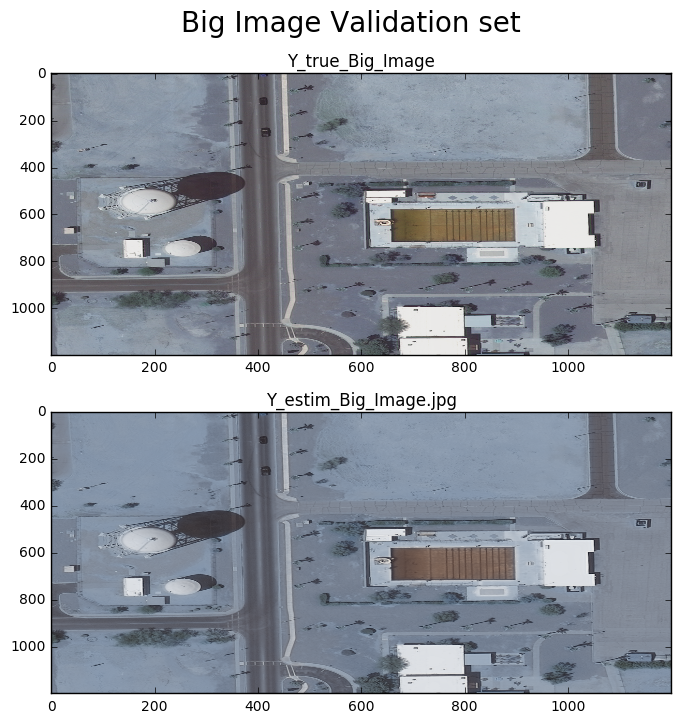

In [9]:
if __name__ == '__main__':
    
    #####CONFIGURATION TO TUNE#####
    #config='train'
    config='predict' 
    
    RESTORE=False
    path_model_stored=GLOBAL_PATH+'srcnn_meli_model.ckpt'
    path_data_to_predict='DATA/images_5/'
    dimensions=[200,1200,200,1200]
    DATA_AUG=False #data augmentation on=True and data augmentation off=False
    #################################
    
    model = CustomCNN()
    if config=='train':
            
        ###TRAIN AND CHECK###
        save_path,psnr_tab_train,psnr_tab_verif=model.train(epochs=DEFAULT_EPOCHS, iterations=DEFAULT_ITERATIONS,batch_size=DEFAULT_BATCH_SIZE,verification_size=DEFAULT_VERIF,restore=RESTORE,model_stored=path_model_stored,disp_verif=True,data_aug=DATA_AUG)
        
        #SAVE PSNR
        plt.title('Plot PSNR', fontsize=20)
        ite = np.arange(0,DEFAULT_EPOCHS*DEFAULT_ITERATIONS,1)
        epo=np.arange((DEFAULT_ITERATIONS-1),(DEFAULT_EPOCHS*DEFAULT_ITERATIONS+(DEFAULT_ITERATIONS-1)),DEFAULT_ITERATIONS)
        plt.plot(ite,psnr_tab_train,'b',epo,psnr_tab_verif,'g')
        plt.ylabel('PSNR')
        plt.show()
        
        #DISPLAY VALIDATION
    
        Y_true,Y_prediction=model.predict_patches(save_path,DEFAULT_VALID)
    
    
        fig, axs = plt.subplots(2,DEFAULT_VALID)

        fig.suptitle('Validation set', fontsize=20)
        fig.set_size_inches(15, 5)   

        for i in range(len(Y_true)): 
            axs[0,i].set_title('Y_true_'+'ite_'+str(i)) 
            axs[0,i].imshow(Y_true[i,:,:,:3], aspect='auto')
            plt.imsave(test_save+'Y_true_'+'ite_'+str(i)+'.jpg',Y_true[i,:,:,:])

            Y_prediction_i=(Y_prediction[i,:,:,:]- np.amin(Y_prediction[i,:,:,:]))/(np.amax(Y_prediction[i,:,:,:])-np.amin(Y_prediction[i,:,:,:]))
            axs[1,i].set_title('Y_estim_'+'ite_'+str(i))
            axs[1,i].imshow(Y_prediction_i[:,:,:3], aspect='auto')
            plt.imsave(test_save+'Y_estim_'+'ite_'+str(i)+'.jpg',Y_prediction_i)
            
     

        
        plt.show()
    elif config=='predict': 

        
        ###CHECK BIG IMAGES###

        save_path=path_model_stored
        Y_true,Y_prediction=model.predict_any_image(raw_imgs_folder=path_data_to_predict, model_path=path_model_stored,crop_size=dimensions)

        fig, axs = plt.subplots(2)


        fig.suptitle('Big Image Validation set', fontsize=20)
        fig.set_size_inches(8, 8)   

        axs[0].set_title('Y_true_Big_Image')
        axs[0].imshow(Y_true[0,:,:,:3], aspect='auto')
        plt.imsave(test_save+'Y_true_Big_Image.jpg',Y_true[0,:,:,:])

        Y_prediction_i=(Y_prediction[0,:,:,:]- np.amin(Y_prediction[0,:,:,:]))/(np.amax(Y_prediction[0,:,:,:])-np.amin(Y_prediction[0,:,:,:]))
        axs[1].set_title('Y_estim_Big_Image.jpg')
        axs[1].imshow(Y_prediction_i[:,:,:3], aspect='auto')
        plt.imsave(test_save+'Y_estim_Big_Image.jpg',Y_prediction_i)


        plt.show()
        
    else: print('Arguments non valid')
    exit()
    
    